In [32]:
import numpy as np
import random
from numpy.linalg import*
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal,stats 
from numpy.fft import fft
import math
import time
import scipy.optimize as opt
from sklearn.decomposition import FastICA, PCA

import scipy.io as sio
import scipy.io.wavfile
import sounddevice as sd
from IPython.display import Audio

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.neighbors import KernelDensity
import copy
%matplotlib inline
import librosa
import librosa.display

import importlib
import functions as lib_HS 
importlib.reload(lib_HS)

import DUET_module_HS_v2 as BSS_DUET
importlib.reload(BSS_DUET)

import DUET_AOA_HS as AOA_DUET
importlib.reload(AOA_DUET)

import MIC_Signal_Mod as MIC_Access
importlib.reload(MIC_Access)

import scipy.stats as stats
import itertools 
#import resampy
#import rir_generator as rir



In [2]:
## LibriTTS dataset import
N_test = 11
N_len = 1800000
TTS = np.zeros((N_test,N_len))
for i in range(1,N_test+1):

    TTS_i_raw, fs_MIC = librosa.load('./TTS_dataset/TTS_norm_'+str(i)+'.wav', sr=None)
    TTS[i-1,:] = TTS_i_raw[:N_len]


print(np.linalg.norm(TTS,ord=2,axis=1))
Data_perm = np.array([[0,1,2],[1,2,3],[2,3,4],[3,4,5],[4,5,6],[5,6,7],[6,7,8],[7,8,9],[8,9,10],[9,10,0],[10,0,2],
                     [0,2,4],[2,4,6],[4,6,8],[10,1,3],[1,3,5],[3,5,7],[5,7,9],[7,9,0],[0,3,6],[3,6,9]])
#Data_numsrc = np.array([[10],[10,1],[10,1,2],[10,1,2,3],[10,1,2,3,4]])
Data_numsrc = np.array([[0],[0,1],[0,1,2],[0,1,2,3],[0,1,2,3,4]])

[41.47506683 41.47511955 41.47498223 41.47508603 41.47458266 41.47509867
 41.47510722 41.47511094 41.47516015 41.47510402 41.47510078]


<ipython-input-2-f816004b9141>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_numsrc = np.array([[0],[0,1],[0,1,2],[0,1,2,3],[0,1,2,3,4]])


In [34]:
############# MIC parameter
M = 2
d = 0.1 ## 10 cm 
SNR = 15
############# Room parameter
Range = 3          # in meter
Room_len = 10      # in meter
z = 1000
T_reverb = 0.45    ## in second
nsample = 4096
dim = 2
order = -1
vp = 343
#################################

[170  70 -50]

------start------
Count: 0
True Angles-local: [170  70 -50]
AoA_est =  [ 49.09413502  71.20324253 170.9037813 ]
height =  0.0
estimated AoAs:  [ 171.   49.  -49. -171.]

------start------
Count: 1
True Angles-local: [170  70 -50]
AoA_est =  [ 49.09413502  73.70181146 145.19718939]
height =  0.5
estimated AoAs:  [ 170.   72.  -50. -123. -170.]

------start------
Count: 2
True Angles-local: [170  70 -50]
AoA_est =  [ 22.32250436  96.56517424 123.4273224 ]
height =  1.0
estimated AoAs:  [170.  71. -50.]

------start------
Count: 3
True Angles-local: [170  70 -50]
AoA_est =  [101.38991822]
height =  1.5
estimated AoAs:  [170.  71. -46.]

------start------
Count: 4
True Angles-local: [170  70 -50]
AoA_est =  [ 14.84189123  78.61008178 141.21897647]
height =  2.0
estimated AoAs:  [170.  72. -47.]

------start------
Count: 5
True Angles-local: [170  70 -50]
AoA_est =  [ 55.13347055 161.05814545]
height =  2.5
estimated AoAs:  [170.  70. -47.]

------start------
Count: 6
True An

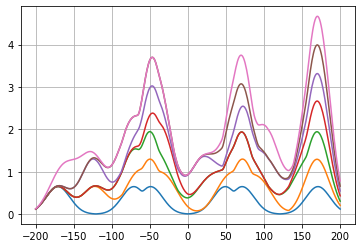

In [40]:
## Program Init.

Angle = np.array([170,70,-50])#, -125]) #,-125])#,10])#, -45, -5])#, 30, 45, 65])     # Impinging Angles from the right
K = len(Angle)      #  Number of impinging signals
Angle_bck = copy.deepcopy(Angle)
print(Angle)

N_len = 3*fs_MIC    # Sample length 
SigVec = np.zeros((K,N_len))



## Exploration Step:

Angle = Angle_bck
count = 0
count_iter = 10 ## number of rotation angles

dtheta_step = 23
rot_ang = np.linspace(0,dtheta_step*(count_iter-1),count_iter)
AoA_D_save = []

perm = 0

while True:
    print('\n------start------')
    print('Count:',count)
    
    SigVec = TTS[Data_numsrc[K-1],N_len*count:N_len*count+N_len]

    X, H = MIC_Access.MixGen_RIR(SigVec, Angle[:K], rot_ang[count], fs_MIC, SNR, vp, d, Range, Room_len, z, T_reverb, nsample, dim, order)
    
    ## Apply DUET after rotation   
    N_fft = 1024    ### L_frame : Lengt of frame
    N_hop = int(N_fft*0.25)  ## Frame_shift
    p,q = 1,0  ## speech case 
    peakdelta = AOA_DUET.DUET(X, fs_MIC, N_fft, N_hop,p,q,0.3, 0.3, 0 , 0)
    AoA_D=np.arccos(-1*(vp/d)*lib_HS.val_clip(peakdelta/fs_MIC,d,vp))*180/np.pi
    print('True Angles-local:',Angle[:K])
    print('AoA_est = ',AoA_D)
    
    
    AoA_cand_p = rot_ang[count] + AoA_D  #  AoA_global x rot_ang
    AoA_cand_n = rot_ang[count] - AoA_D   #  AoA_global x rot_ang
    AoA_cand = lib_HS.AoA_clip(np.concatenate((AoA_cand_p, AoA_cand_n)))
    AoA_D_save.append(AoA_cand)
    Angle_est,peak_prom = lib_HS.getAoA(AoA_D_save, count)
    if np.average(peak_prom) > 3:
        rot_ang_last = rot_ang[count]
        break
    #AoA_D_save = np.append(AoA_D_save,AoA_cand)
    count = count+1



In [29]:
lib_HS.Find_AlignRotAng(Angle_est,0)

116.5

In [19]:
print(rot_ang_last)

115.0


In [31]:
Angle_est

array([165.,  68.])

---------------------
Angle_rot  : 11.5
Angle_meas : [158.5  58.5 -61.5]


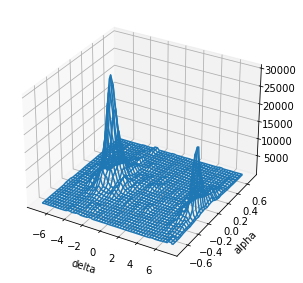

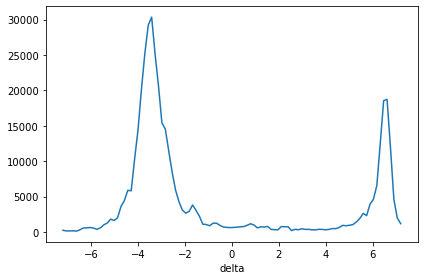

number of peaks:  2
AoA_est =  [ 60.75696657 161.05814545]
SI_SDR: Src(0),Est(0):  -29.3956902595449
SI_SDR: Src(0),Est(1):  8.76342131359438
SI-SDR_mix:  -2.902532169532546
---------------------
Angle_rot  : 61.5
Angle_meas : [ 108.5    8.5 -111.5]


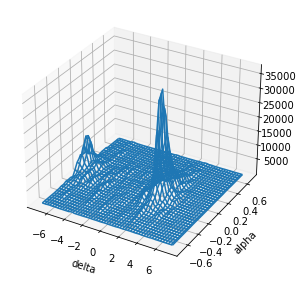

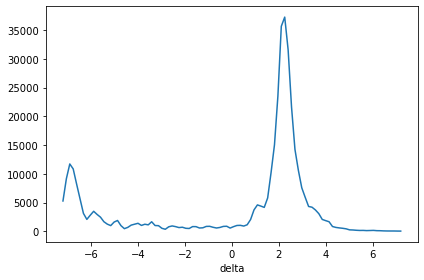

number of peaks:  1
AoA_est =  [108.79675747]
SI_SDR: Src(1),Est(0):  -7.297563392947614
SI-SDR_mix:  -4.154727182897396
---------------------
Angle_rot  : 120.0
Angle_meas : [  50.  -50. -170.]


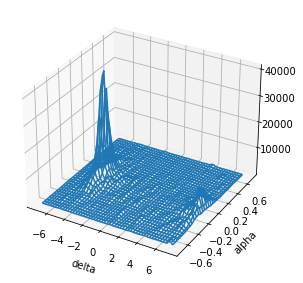

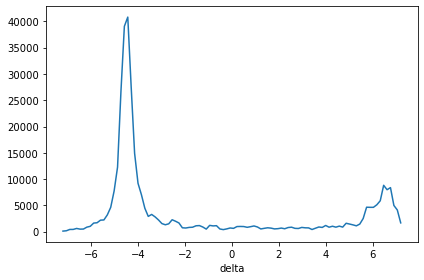

number of peaks:  1
AoA_est =  [50.6518991]
SI_SDR: Src(2),Est(0):  -5.840252876998927
SI-SDR_mix:  -2.537659358879454


In [41]:
#### Source Separation Module (DUET) :

numsrc = len(Angle_est)
perm = 9
count = 1
Ns_true = 5*fs_MIC
#SigVec = TTS[Data_perm[perm],Ns_true*count:Ns_true*count+Ns_true]
SigVec_test = TTS[Data_numsrc[numsrc-1],Ns_true*count:Ns_true*count+Ns_true]


SigVec_meas = np.zeros((numsrc,Ns_true))
Angle_test = lib_HS.AoA_clip(Angle_bck[:numsrc])

for i in range(numsrc):
    Angle_rot = lib_HS.Find_AlignRotAng(Angle_est,i)   ## with estimated rotation
    if len(Angle_est)==1:
        Angle_rot = rot_ang_last
    
    
    #Angle_rot = lib_HS.Find_AlignRotAng(Angle_bck,i))   ## oracle rotation
    #Angle_test = Angle_bck[:numsrc]                                          ## with no rotation
    print("---------------------")
    print("Angle_rot  :",Angle_rot)
    print("Angle_meas :",Angle_test-np.array(Angle_rot)) 


    X, H = MIC_Access.MixGen_RIR(SigVec_test, Angle_test, Angle_rot, fs_MIC, SNR, vp, d, Range, Room_len, z, T_reverb, nsample, dim, order)

    X_single, _ = MIC_Access.MixGen_RIR_single(SigVec_test[i], Angle_test[i], Angle_rot, fs_MIC, SNR, vp, d, Range, Room_len, z, T_reverb, nsample, dim, 0)
    SigVec_meas[i,:] = X_single[0]  ### index 0 MIC is the reference

     ## DUET

    N_fft = 2*512    ### L_frame : Lengt of frame
    N_hop = int(0.25*N_fft)
    p,q = 1,0  ## speech case
    y_D, peakdelta, _ = BSS_DUET.DUET(X, fs_MIC, N_fft, N_hop, p, q, 0.3, 0.3, 0 , 1)

    AoA_D=np.arccos(-1*(vp/d)*lib_HS.val_clip(peakdelta/fs_MIC,d,vp))*180/np.pi

    print('AoA_est = ',AoA_D)    
    for p in range(len(peakdelta)):
        print("SI_SDR: Src(%d),Est(%d): "%(i,p),lib_HS.eval_SI_SDR(y_D[p,:],SigVec_meas[i,:]))
    print("SI-SDR_mix: ",lib_HS.eval_SI_SDR(X[0,:],SigVec_meas[i,:]))

    

